In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer 
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

In [2]:
house_price = pd.read_csv("Data/housing_iter_5/housing-classification-iter5.csv")
house_price

,LotArea,LotFrontage,TotalBsmtSF,BedroomAbvGr,Fireplaces,PoolArea,GarageCars,WoodDeckSF,ScreenPorch,Expensive,...,KitchenAbvGr,TotRmsAbvGrd,GarageYrBlt,GarageArea,OpenPorchSF,EnclosedPorch,3SsnPorch,MiscVal,MoSold,YrSold
0,8450,65.0,856,3,0,0,2,0,0,0,...,1,8,2003.0,548,61,0,0,0,2,2008
1,9600,80.0,1262,3,1,0,2,298,0,0,...,1,6,1976.0,460,0,0,0,0,5,2007
2,11250,68.0,920,3,1,0,2,0,0,0,...,1,6,2001.0,608,42,0,0,0,9,2008
3,9550,60.0,756,3,1,0,3,0,0,0,...,1,7,1998.0,642,35,272,0,0,2,2006
4,14260,84.0,1145,4,1,0,3,192,0,0,...,1,9,2000.0,836,84,0,0,0,12,2008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,7917,62.0,953,3,1,0,2,0,0,0,...,1,7,1999.0,460,40,0,0,0,8,2007
1456,13175,85.0,1542,3,2,0,2,349,0,0,...,1,7,1978.0,500,0,0,0,0,2,2010
1457,9042,66.0,1152,4,2,0,1,0,0,1,...,1,9,1941.0,252,60,0,0,2500,5,2010
1458,9717,68.0,1078,2,0,0,1,366,0,0,...,1,5,1950.0,240,0,112,0,0,4,2010


In [3]:
house_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 51 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   LotArea        1460 non-null   int64  
 1   LotFrontage    1201 non-null   float64
 2   TotalBsmtSF    1460 non-null   int64  
 3   BedroomAbvGr   1460 non-null   int64  
 4   Fireplaces     1460 non-null   int64  
 5   PoolArea       1460 non-null   int64  
 6   GarageCars     1460 non-null   int64  
 7   WoodDeckSF     1460 non-null   int64  
 8   ScreenPorch    1460 non-null   int64  
 9   Expensive      1460 non-null   int64  
 10  MSZoning       1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Heating        1460 non-null   object 
 13  Street         1460 non-null   object 
 14  CentralAir     1460 non-null   object 
 15  Foundation     1460 non-null   object 
 16  ExterQual      1460 non-null   object 
 17  ExterCond      1460 non-null   object 
 18  BsmtQual

In [4]:
y = house_price.pop("Expensive")
X = house_price.copy()

In [5]:
# split the dataset into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)

In [6]:
# select categorical and numerical column names
X_num_col = X.select_dtypes(include = "number").copy().columns
X_cat_col = X.select_dtypes(exclude = "number").copy().columns

# define ordinal and onehot columns
onehot_col = X_cat_col.get_indexer(["MSZoning", "Condition1", "Heating", "Street", "CentralAir", "Foundation"])
ord_col = X_cat_col.get_indexer(["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "BsmtExposure", 
                                 "BsmtFinType1", "KitchenQual", "FireplaceQu"])

# define categories for all ordinal columns
exqual_cat = ["Ex", "Gd", "TA", "Fa", "Po", "NA"]
excond_cat = ["Ex", "Gd", "TA", "Fa", "Po", "NA"]
bsmtqual_cat = ["Ex", "Gd", "TA", "Fa", "Po", "NA"]
bsmtcond_cat = ["Ex", "Gd", "TA", "Fa", "Po", "NA"]
bsmtex_cat = ["Gd", "Av", "Mn", "No", "NA"]
bsmtfin_cat = ["GLQ", "ALQ", "BLQ", "Rec", "LwQ", "Unf", "NA"]
kitqual_cat = ["Ex", "Gd", "TA", "Fa", "Po", "NA"]
firequal_cat = ["Ex", "Gd", "TA", "Fa", "Po", "NA"]

# define encoder for all categorial columns
categorical_encoder = make_column_transformer(
    (OneHotEncoder(handle_unknown = "ignore"), onehot_col),
    (OrdinalEncoder(categories = [exqual_cat, excond_cat, bsmtqual_cat, bsmtcond_cat, bsmtex_cat, 
                                  bsmtfin_cat, kitqual_cat, firequal_cat]), ord_col))

# create pipeline for all categorical columns
cat_pipeline = make_pipeline(SimpleImputer(strategy = "constant", fill_value = "NA"), categorical_encoder)

# create pipeline for all numerical columns
num_pipeline = make_pipeline(SimpleImputer(strategy = "mean"), StandardScaler())

# create pipeline for the entire preprocessing for all columns
preprocess = ColumnTransformer(transformers = [("num_pipeline", num_pipeline, X_num_col),
                                               ("cat_pipeline", cat_pipeline, X_cat_col)])

In [7]:
full_pipeline = make_pipeline(preprocess, KNeighborsClassifier())
full_pipeline.fit(X_train, y_train)
full_pipeline.predict(X_train)

array([0, 1, 0, ..., 0, 0, 1])

In [18]:
# create the full pipeline with knn algorithm
full_pipeline = make_pipeline(preprocess, KNeighborsClassifier())

# define parameter grid and use grid search to find the best hyperparameter
param_grid = {"columntransformer__num_pipeline__simpleimputer__strategy": ["mean", "median"],
              "kneighborsclassifier__n_neighbors": range(5, 70),
              "kneighborsclassifier__weights": ["uniform", "distance"],
              # "kneighborsclassifier__leaf_size": range(20, 41)
             }
search = GridSearchCV(full_pipeline, param_grid, cv = 5, verbose = 1)
search.fit(X_train, y_train)

Fitting 5 folds for each of 260 candidates, totalling 1300 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num_pipeline',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['LotArea', 'LotFrontage', 'TotalBsmtSF', 'BedroomAbvGr', 'Fireplaces',
       'PoolArea', 'GarageCars', 'WoodDeckSF', 'ScreenPorch', 'MSSubClass',
       'OverallQual...
       'Foundation', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'KitchenQual', 'FireplaceQu'],
      

In [19]:
search.best_params_

{'columntransformer__num_pipeline__simpleimputer__strategy': 'mean',
 'kneighborsclassifier__n_neighbors': 14,
 'kneighborsclassifier__weights': 'distance'}

In [20]:
search.best_score_

0.9306481787168481

In [21]:
y_train_pred = search.predict(X_train)
accuracy_score(y_true = y_train, y_pred = y_train_pred)

1.0

In [22]:
y_test_pred = search.predict(X_test)
accuracy_score(y_true = y_test, y_pred = y_test_pred)

0.9417808219178082

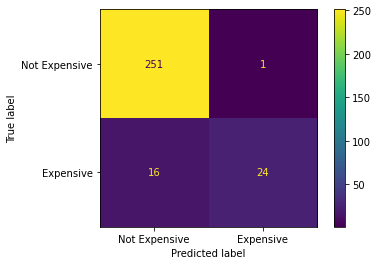

In [23]:
ConfusionMatrixDisplay.from_estimator(search, X_test, y_test, display_labels = ["Not Expensive", "Expensive"]);